# XGB Classifier with Filter-Based FS

Steven Sison | March 9, 2024

## Description

This document will be used to train a model using the reduced feature set obtain by using the wrapper-based method, forward feature selection. The model will be evaluated in terms of the usual metrics (accuracy, precision, F1-score, recall) as well as the training time. The model will also be stored for future evaluation purposes.

## Training the Model

### Preliminaries

#### 1. Loading the Dataset

In [1]:
import pandas as pd                     # For data transformation
import numpy as numpy                   # For scientific calculations
import seaborn as sns                   # For data visualizations
import matplotlib.pyplot as plt         # For plotting
import plotly.graph_objects as go       # For plotting
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import time
from datetime import datetime
import joblib
import os

dataset = pd.read_csv("../../../02_feature-engineering/final-datasets/final_unbalanced_withLexical.csv")      # Loading the dataset

dataset.head()

,url_type,url_length,url_ip_in_domain,url_domain_entropy,url_is_digits_in_domain,url_query_length,url_number_of_parameters,url_number_of_digits,url_string_entropy,url_is_https,...,has_swf_in_string,has_cgi_in_string,has_php_in_string,has_abuse_in_string,has_admin_in_string,has_bin_in_string,has_personal_in_string,has_update_in_string,has_verification_in_string,url_scheme
0,2,16,0,3.169925,0,0,0,0,3.375000,0,...,0,0,0,0,0,0,0,0,0,0
1,0,35,0,2.807355,1,0,0,1,4.079143,0,...,0,0,0,0,0,0,0,0,0,0
2,0,31,0,2.921928,0,0,0,1,3.708093,0,...,0,0,0,0,0,0,0,0,0,0
3,1,88,0,2.896292,0,49,4,7,4.660343,0,...,0,0,1,0,0,0,0,0,0,27
4,1,235,0,3.405822,0,194,3,22,4.980518,0,...,0,0,1,0,0,0,0,0,0,27


In [2]:
dataset.head()

,url_type,url_length,url_ip_in_domain,url_domain_entropy,url_is_digits_in_domain,url_query_length,url_number_of_parameters,url_number_of_digits,url_string_entropy,url_is_https,...,has_swf_in_string,has_cgi_in_string,has_php_in_string,has_abuse_in_string,has_admin_in_string,has_bin_in_string,has_personal_in_string,has_update_in_string,has_verification_in_string,url_scheme
0,2,16,0,3.169925,0,0,0,0,3.375000,0,...,0,0,0,0,0,0,0,0,0,0
1,0,35,0,2.807355,1,0,0,1,4.079143,0,...,0,0,0,0,0,0,0,0,0,0
2,0,31,0,2.921928,0,0,0,1,3.708093,0,...,0,0,0,0,0,0,0,0,0,0
3,1,88,0,2.896292,0,49,4,7,4.660343,0,...,0,0,1,0,0,0,0,0,0,27
4,1,235,0,3.405822,0,194,3,22,4.980518,0,...,0,0,1,0,0,0,0,0,0,27


In [3]:
x_train, x_test, y_train, y_test = train_test_split(dataset.drop(columns=['url_type']), dataset['url_type'], test_size = 0.2, random_state=42)

#### 2. Preprocessing (Balancing)

In [4]:
dataset['url_type'].value_counts()

url_type
0    428080
2    134094
1     95308
3     26700
Name: count, dtype: int64

#### 3. Removing Unnecessary Features

In [5]:
important_features_hybrid = ['url_is_digits_in_domain',
                             'url_query_length',
                             'url_number_of_parameters',
                             'url_string_entropy',
                             'url_path_length',
                             'url_host_length',
                             'get_tld',
                             'url_num_periods',
                             'has_exe_in_string',
                             'has_php_in_string',
                             'url_scheme']

print(len(important_features_hybrid))

X_test = x_test[important_features_hybrid]
X_train = x_train[important_features_hybrid]

11


#### Model Training

In [6]:
from sklearn.model_selection import KFold

# Initialize CV
cv = KFold(n_splits=10, shuffle=True, random_state=1)

# Set Hyperparameters
params_gbm = {'eta': 0.2660984929457465,
              'objective': 'multi:softmax',
              'num_class': 4,
              'max_depth': 10,
              'subsample': 0.8197225669267219,
              'colsample_bytree': 0.9893540865745749,
              'gamma': 0.05040746966680979,
              'min_child_weight': 5.3821851133593634,
              'lambda': 0.9274786210352317,
              'alpha': 3.6297170639237653,
              'num_boost_round': 50000
              }

# Initialize the model
xgb_classifier = XGBClassifier(params_gbm)

# Train the Model
eval_set = [(x_test, y_test)]

xgb_classifier.fit(X_train, y_train, eval_metric="error", verbose=True)
y_pred = xgb_classifier.predict(X_test)

c:\Users\sison\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\sison\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


#### Evaluation

In [7]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93     85560
           1       0.92      0.98      0.95     18804
           2       0.84      0.60      0.70     27061
           3       0.98      0.88      0.93      5412

    accuracy                           0.89    136837
   macro avg       0.91      0.86      0.88    136837
weighted avg       0.89      0.89      0.89    136837



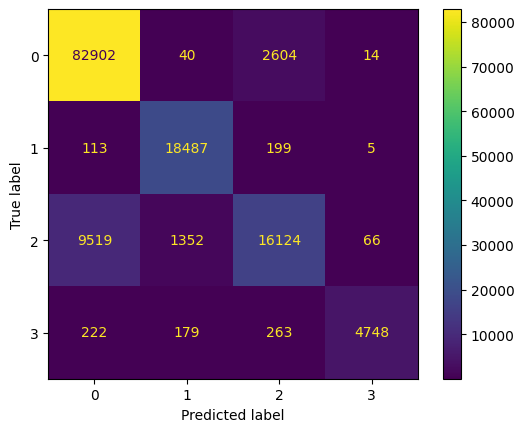

In [8]:
# Confusion Matrix for 12 Features
cm_up = confusion_matrix(y_test, y_pred, labels=xgb_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_up, display_labels = xgb_classifier.classes_)
disp.plot()
plt.show()

In [9]:
'''# Cross Validation Score
scores = cross_val_score(XGBClassifier(**params_gbm),
                        X_train, y_train, scoring='accuracy', cv=cv).mean()

print(scores)'''

"# Cross Validation Score\nscores = cross_val_score(XGBClassifier(**params_gbm),\n                        X_train, y_train, scoring='accuracy', cv=cv).mean()\n\nprint(scores)"

In [10]:
# Dumping the model
joblib.dump(xgb_classifier, 'xgb_filter.sav')

['xgb_filter.sav']

In [15]:
import lexical_generator_hybrid
import time

def xgb_predict_maliciousness(url):

    numerical_values = lexical_generator_hybrid.lexical_generator(url)
    # print(numerical_values)

    match xgb_classifier.predict(numerical_values):
        case 0:
            return "Benign"
        case 1:
            return "Malware"
        case 2:
            return "Phishing"
        case 3:
            return "Defacement"

url = "medium.com/"
print("Current URL: "+url)

start = time.perf_counter()
prediction = xgb_predict_maliciousness(url)
end = time.perf_counter()
print("------- 12 Features -------------")
print(prediction)
print(end-start)

Current URL: medium.com/
------- 12 Features -------------
Phishing
0.015586800000164658
